In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append('../')

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms

from lumivid.utils.model_utils import get_class_weights, show_learning_curves, load_model
from lumivid.utils.video_utils import get_video, get_frame_from_video
from lumivid.sky_cloud_segmentation_dl.dataset import get_dataloaders
from lumivid.sky_ground_segmentation.train import get_model as get_ground_model
from lumivid.sky_cloud_segmentation_dl.train import get_model as get_cloud_model
from lumivid.utils.model_utils import get_class_weights
from lumivid.utils.random_utils import set_seed

DATA_PATH = '../data/'
SCS_DATA_PATH = DATA_PATH + 'sky_cloud_segmentation/'
SKY_FINDER_PATH = SCS_DATA_PATH + "sky_finder/"
SKY_FINDER_INPUTS_PATH = SKY_FINDER_PATH + "images/"

BATCH_SIZE = 4

CLASS_WEIGHTS = torch.tensor([[2.14396795, 4.16733798, 3.40583472]])
# CLASS_WEIGHTS = CLASS_WEIGHTS.view(1, 3, 1, 1)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
set_seed(SEED)

In [7]:
train_loader, val_loader = get_dataloaders(BATCH_SIZE, use_workers=False)

✅ Created SeededDataLoader with seed 42.

➡️ Number of train images: 51
➡️ Number of val images: 13


In [8]:
# Get class weights
# get_class_weights(train_loader, n_classes=3, binary=True)
# => array([2.14396795, 4.16733798, 3.40583472])

In [9]:
# Show training sample image
it = iter(train_loader)

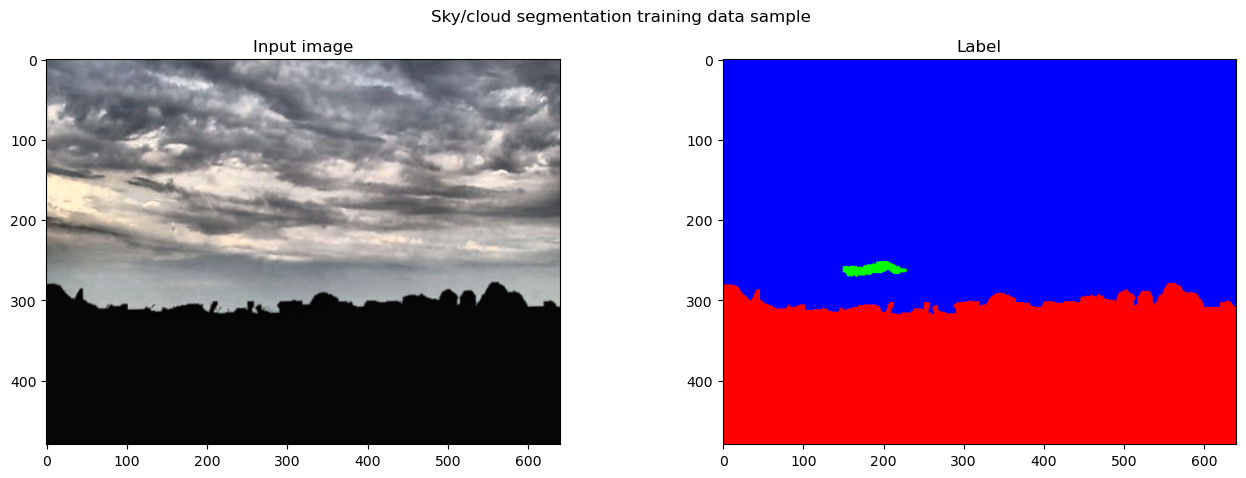

In [10]:
sample_input, sample_mask = next(it)
sample_input = sample_input[0].permute(1, 2, 0).cpu().numpy()
sample_mask = sample_mask[0].permute(1, 2, 0).cpu().numpy()

# Normalize back to [0,1]
sample_input = (sample_input * IMAGENET_STD) + IMAGENET_MEAN
sample_input = np.clip(sample_input, 0, 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_input)
plt.title("Input image")
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, vmin=0, vmax=1)
plt.title("Label")
plt.suptitle("Sky/cloud segmentation training data sample")
plt.show()

In [11]:
# Show validation sample image
it = iter(val_loader)

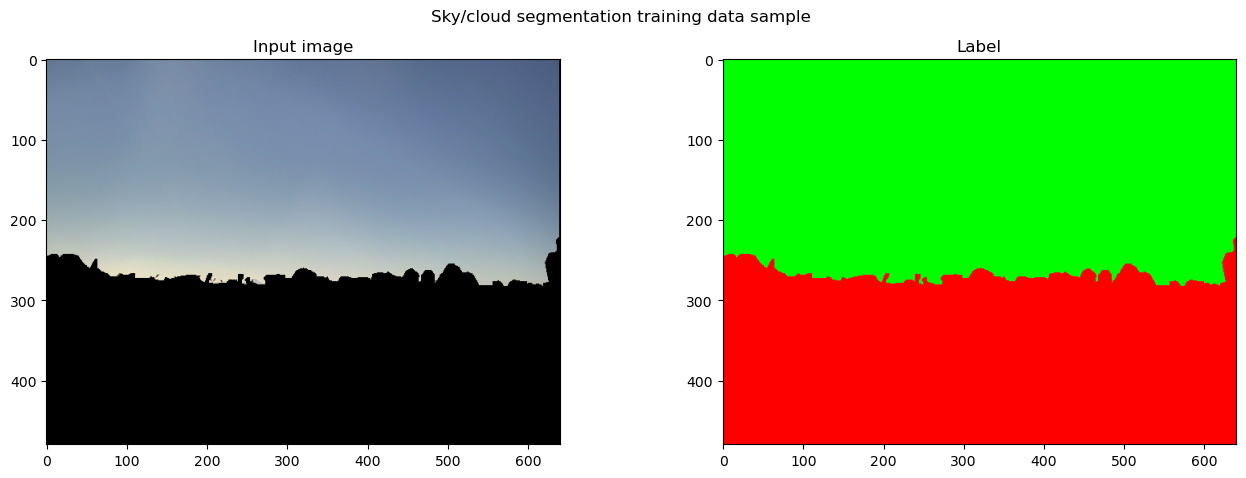

In [12]:
# show from validation set
sample_input, sample_mask = next(it)
sample_input = sample_input[0].permute(1, 2, 0).cpu().numpy()
sample_mask = sample_mask[0].permute(1, 2, 0).cpu().numpy()

# Normalize back to [0,1]
sample_input = (sample_input * IMAGENET_STD) + IMAGENET_MEAN
sample_input = np.clip(sample_input, 0, 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_input)
plt.title("Input image")
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, vmin=0, vmax=1)
plt.title("Label")
plt.suptitle("Sky/cloud segmentation training data sample")
plt.show()

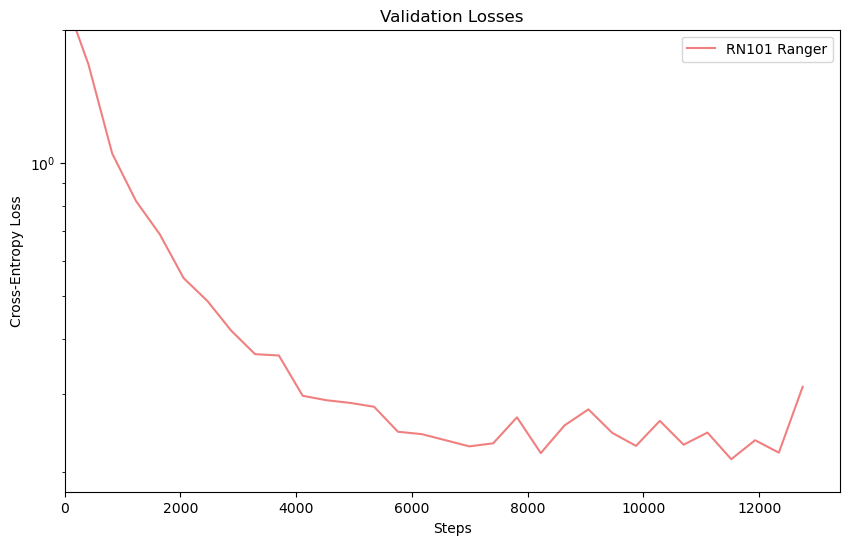

In [13]:
model_file_dir = "../data/sky_cloud_segmentation/models/"
name_dict = {
        'deeplabv3resnet101_ranger_info': 'RN101 Ranger',
}
color_dict = {
    'deeplabv3resnet101_ranger_info': 'lightcoral',
}
show_learning_curves(model_file_dir, y_lim=(0.18, 2.0), default_max_steps=12750, color_dict=color_dict, name_dict=name_dict, window_size=1)

In [14]:
# Get ground model and load weights
model_type = 'deeplabv3resnet101'
optimizer_type = 'ranger'
model_save_path = f"../data/sky_ground_segmentation/models/{model_type}_{optimizer_type}_pretrained.pth"
ground_model = get_ground_model(model_type, n_classes=2, pretrained=False)
load_model(ground_model, model_save_path, force=True)

✅ Loaded model deeplabv3resnet101 with 60,991,319 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3resnet101_ranger_pretrained.pth


In [16]:
# Get cloud model and load weights
model_type = 'deeplabv3resnet101'
optimizer_type = 'ranger'
model_save_path = f"../data/sky_cloud_segmentation/models/{model_type}_{optimizer_type}_.pth"
cloud_model = get_cloud_model(n_classes=3)
load_model(cloud_model, model_save_path, force=True)

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_.pth


In [42]:
import os
from tqdm import tqdm

IMAGE_HEIGHT, IMAGE_WIDTH = 480, 640

SCS_DATA_PATH = DATA_PATH + 'sky_cloud_segmentation/'

SKY_FINDER_SEG_TE_PATH = SCS_DATA_PATH + "sky_finder_segmented/test/"
SKY_FINDER_SEG_TE_INPUTS_PATH = SKY_FINDER_SEG_TE_PATH + "filtered_images/"
SKY_FINDER_SEG_TE_MASKS_PATH = SKY_FINDER_SEG_TE_PATH + "masks/"
SKY_FINDER_SEG_TE_LABELS_PATH = SKY_FINDER_SEG_TE_PATH + "labels/"

input_paths = []
mask_paths = []
label_paths = []

# Sky finder segmented
input_folder_paths = sorted([os.path.join(SKY_FINDER_SEG_TE_INPUTS_PATH, folder) for folder in os.listdir(SKY_FINDER_SEG_TE_INPUTS_PATH)])
for folder_path in input_folder_paths:
    image_paths = sorted([os.path.join(folder_path, filename) for filename in os.listdir(folder_path)])
    for image_path in image_paths:
        input_paths.append(image_path)
        folder = folder_path.split("/")[-1]
        mask_paths.append(f"{SKY_FINDER_SEG_TE_MASKS_PATH}{folder}.png")
        label_paths.append(image_path.replace(SKY_FINDER_SEG_TE_INPUTS_PATH, SKY_FINDER_SEG_TE_LABELS_PATH).replace(".jpg", ".png"))

accuracies = []
f1s = []
jacards = []
for input_path, mask_path, label_path in tqdm(zip(input_paths, mask_paths, label_paths), total=len(input_paths), desc="▶️ Extracting features"):
    # Get image and mask
    image = np.array(Image.open(input_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT)))
    mask = np.array(Image.open(mask_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT)))
    label = np.array(Image.open(label_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT)))

    # Apply mask to image
    image = image * mask[:, :, np.newaxis]
    label = label * mask[:, :, np.newaxis]

    # Get label masks
    r_label = label[:, :, 0]
    g_label = label[:, :, 1]
    b_label = label[:, :, 2]
    ground_mask = np.where(r_label + g_label + b_label < 10, 1, 0).astype(bool)
    sky_mask = np.where(b_label - r_label - g_label > 128, 1, 0).astype(bool)
    light_cloud_mask = np.where(g_label - r_label - b_label > 128, 1, 0).astype(bool)
    thick_cloud_mask = np.where(r_label - g_label - b_label > 128, 1, 0).astype(bool)

    # Predict sky/cloud
    input_image = torch.tensor(image).permute(2, 0, 1).float()
    input_image = input_image / 255.
    input_image = input_image - torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    input_image = input_image / torch.tensor(IMAGENET_STD).view(3, 1, 1)
    input_image = input_image.unsqueeze(0).to(DEVICE)

    cloud_model.eval()
    with torch.no_grad():
        cloud_pred = cloud_model(input_image)
        cloud_pred = cloud_pred['out']
        cloud_pred = torch.argmax(cloud_pred, dim=1).squeeze().cpu().numpy()

    cloud_pred = cloud_pred[ground_mask]
    cloud_target = np.zeros_like(cloud_pred)
    cloud_target[sky_mask[ground_mask]] = 1
    cloud_target[light_cloud_mask[ground_mask]] = 2
    cloud_target[thick_cloud_mask[ground_mask]] = 2

    # Get accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(cloud_target, cloud_pred)
    accuracies.append(accuracy)

    # Get f1
    from sklearn.metrics import f1_score
    f1 = f1_score(cloud_target, cloud_pred, average='weighted')
    f1s.append(f1)

    # Get Jacard
    from sklearn.metrics import jaccard_score
    jacard = jaccard_score(cloud_target, cloud_pred, average='weighted')
    jacards.append(jacard)

mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1s)
mean_jacard = np.mean(jacards)

std_accuracy = np.std(accuracies)
std_f1 = np.std(f1s)
std_jacard = np.std(jacards)

print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Jacard: {mean_jacard:.4f} ± {std_jacard:.4f}")

▶️ Extracting features: 100%|██████████| 13/13 [00:01<00:00,  9.48it/s]

Accuracy: 0.9926 ± 0.0017
F1: 0.9963 ± 0.0009
Jacard: 0.9926 ± 0.0017


In [17]:
def predict_mask(model: nn.Module, input_image: torch.Tensor) -> torch.Tensor:
    """
    Predict mask from input image.

    Args:
        model (nn.Module): Model.
        input_image (torch.Tensor): Input image.

    Returns:
        predicted_mask (torch.Tensor): Predicted mask.
    """

    # Normalize input image in [0, 1] range if needed
    if input_image.dtype == torch.uint8:
        input_image = input_image.float() / 255.

    # Add batch dimension if needed
    if len(input_image.shape) == 3:
        input_image = input_image.unsqueeze(0)

    # Normalize input image
    input_image = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)(input_image)

    input_image = input_image.to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model(input_image)
        output = output['out']
        output = output.squeeze(0).squeeze(0).cpu()
        predicted_mask = np.argmax(output.numpy(), axis=0)
    model.train()
    
    return predicted_mask

def get_overlayed_image(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """
    Get overlayed image.

    Args:
        image (np.ndarray): Input image, with values in [0, 255] range.
        mask (np.ndarray): Predicted binary mask.

    Returns:
        overlayed_image (np.ndarray): Overlayed image in red, with values in [0, 255] range.
    """

    # Resize mask to image size
    mask = Image.fromarray(mask * 127.5)
    mask = mask.resize((image.shape[1], image.shape[0]), resample=Image.BILINEAR)
    mask = (np.array(mask) / 127.5).astype(int)

    # Get overlayed image
    image = np.array(image) / 255.
    red_overlay = np.zeros_like(image)
    red_overlay[mask == 2] = [0, 0.5, 0.5]  # Set ground (class 0) pixels to bright red
    overlayed_image = np.clip((image - red_overlay) * 255, 0, 255).astype(np.uint8)
    
    return overlayed_image

def show_prediction_from_image(model: nn.Module, image_path: str) -> None:
    """
    Show prediction from image.

    Args:
        model (nn.Module): Model.
        image_path (str): Path to image.
    """

    # Get image
    image = np.array(Image.open(image_path))
    input_image = torch.tensor(image).permute(2, 0, 1)

    # Predict ground mask and apply to image
    predicted_ground_mask = predict_mask(ground_model, input_image)
    image = image * predicted_ground_mask[:, :, np.newaxis]

    # Predict cloud mask
    input_image = torch.tensor(image).permute(2, 0, 1).type(torch.uint8)
    predicted_cloud_mask = predict_mask(cloud_model, input_image)

    # Get overlayed image
    overlayed_image = get_overlayed_image(image, predicted_cloud_mask)

    # Show image
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_cloud_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title("Input Image with Predicted Mask")
    plt.suptitle("Sky Ground Segmentation Prediction")
    plt.show()

def show_prediction_from_video_frame(model: nn.Module, video_path: str, frame_idx: int) -> None:
    """
    Show prediction from video frame.

    Args:
        model (nn.Module): Model.
        video_path (str): Path to video.
        frame_idx (int): Frame index.
    """

    # Load video
    video = get_video(video_path)
    frame, _ = get_frame_from_video(video, frame_idx, split=False)
    frame = frame[:, :, ::-1] # BGR to RGB

    # Get input image
    image = frame.copy()
    input_image = torch.tensor(image).permute(2, 0, 1)

    # Predict ground mask and apply to image
    predicted_ground_mask = predict_mask(ground_model, input_image)
    image = image * predicted_ground_mask[:, :, np.newaxis]

    # Predict cloud mask
    input_image = torch.tensor(image).permute(2, 0, 1).type(torch.uint8)
    predicted_cloud_mask = predict_mask(cloud_model, input_image)

    # Get overlayed image
    overlayed_image = get_overlayed_image(frame, predicted_cloud_mask)

    # Show image
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(frame)
    plt.title("Input Image")
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_cloud_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title("Input Image with Predicted Mask")
    plt.suptitle("Sky Ground Segmentation Prediction")
    plt.show()

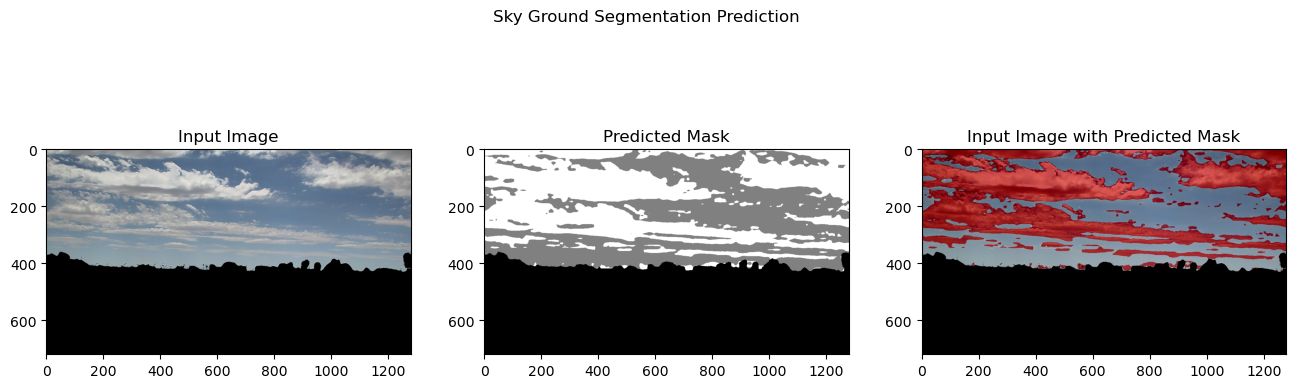

In [18]:
image_example_path = SKY_FINDER_INPUTS_PATH + '65/20130810_203311.jpg'
show_prediction_from_image(cloud_model, image_example_path)

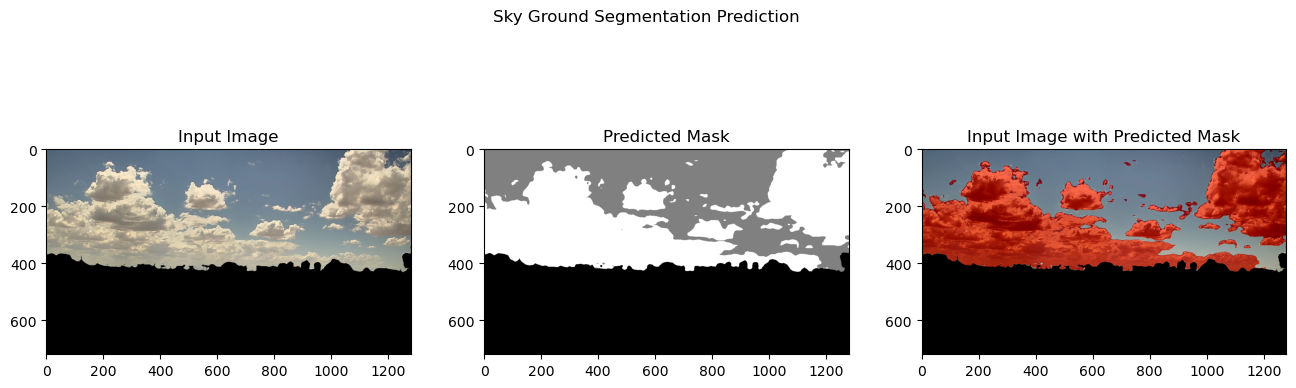

In [19]:
image_example_path = SKY_FINDER_INPUTS_PATH + '65/20140822_210310.jpg'
show_prediction_from_image(cloud_model, image_example_path)

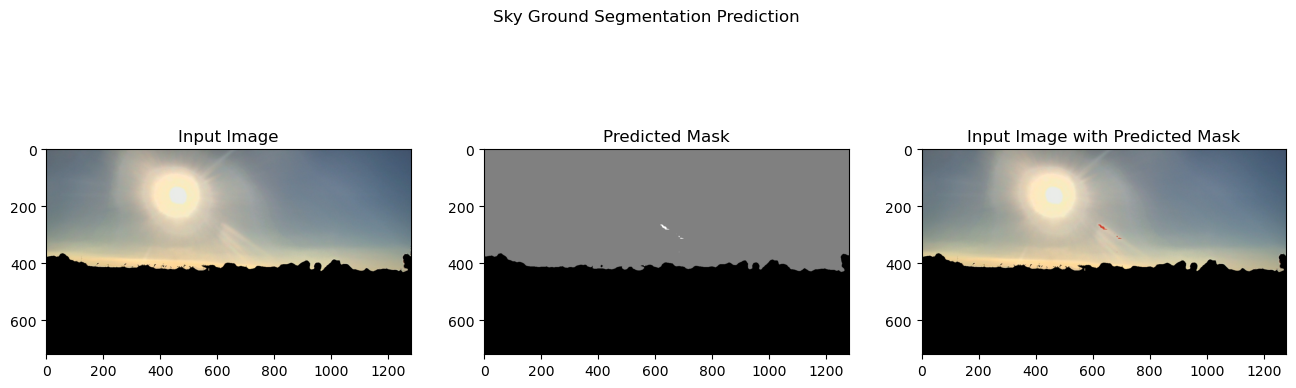

In [20]:
image_example_path = SKY_FINDER_INPUTS_PATH + '65/20130205_000309.jpg'
show_prediction_from_image(cloud_model, image_example_path)

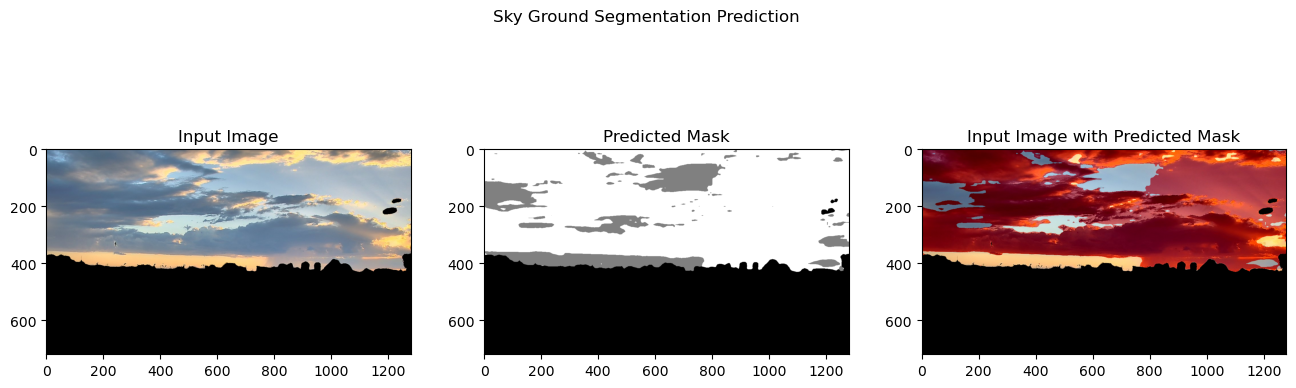

In [21]:
image_example_path = SKY_FINDER_INPUTS_PATH + '65/20140820_020310.jpg'
show_prediction_from_image(cloud_model, image_example_path)

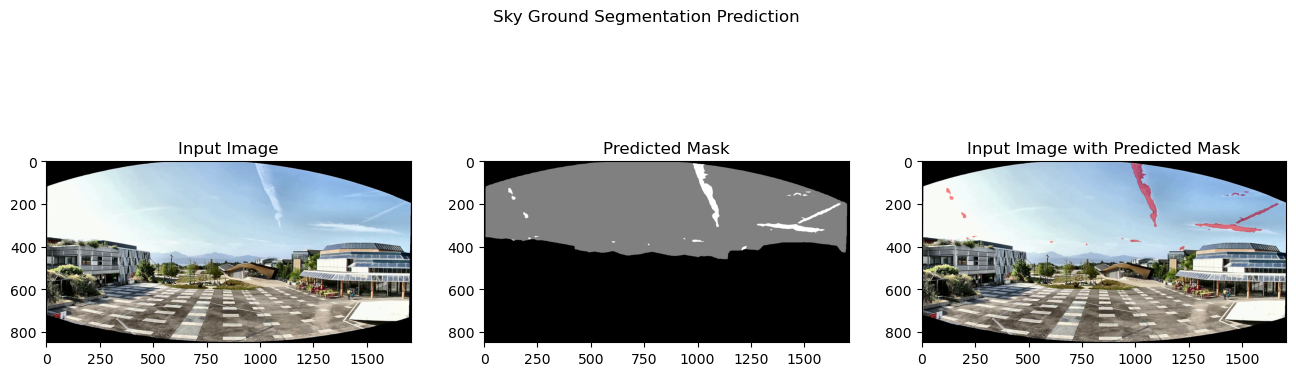

In [22]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene01.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

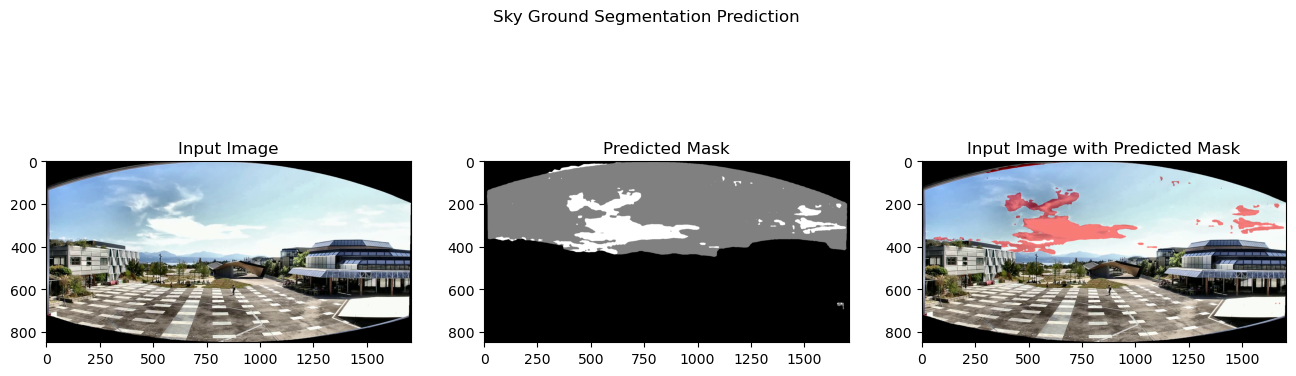

In [23]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene02.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

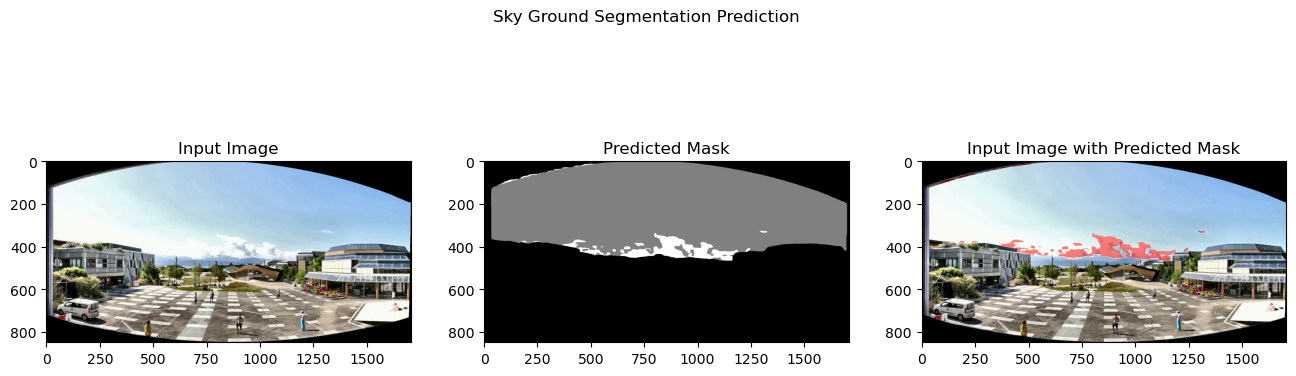

In [24]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene03.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

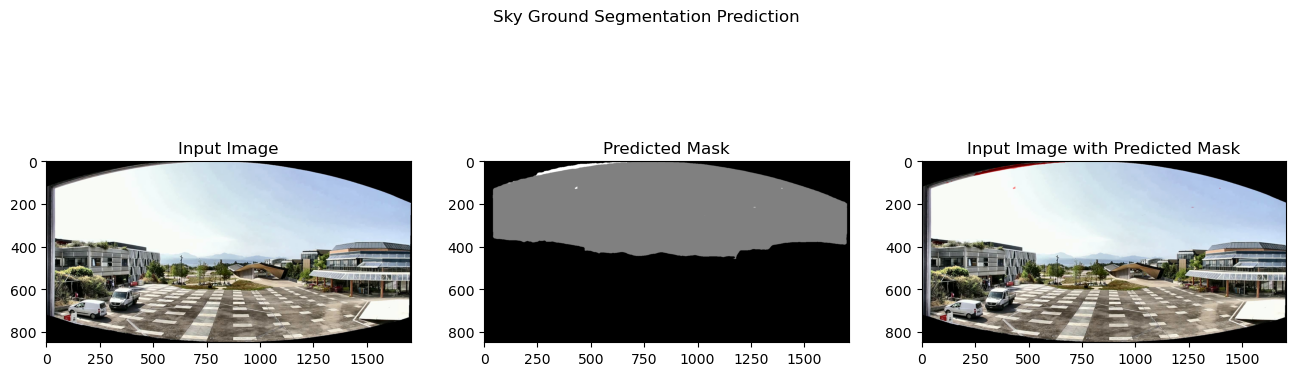

In [25]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene04.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

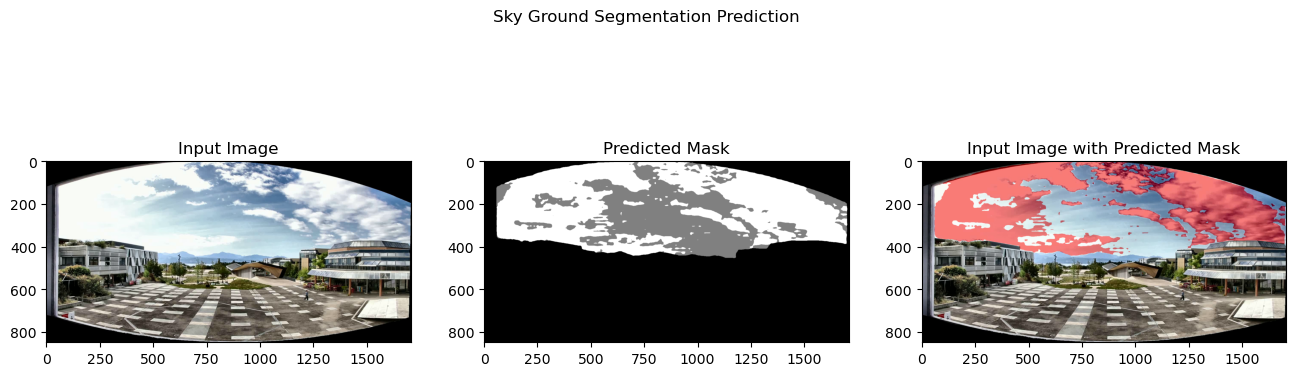

In [26]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene05.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

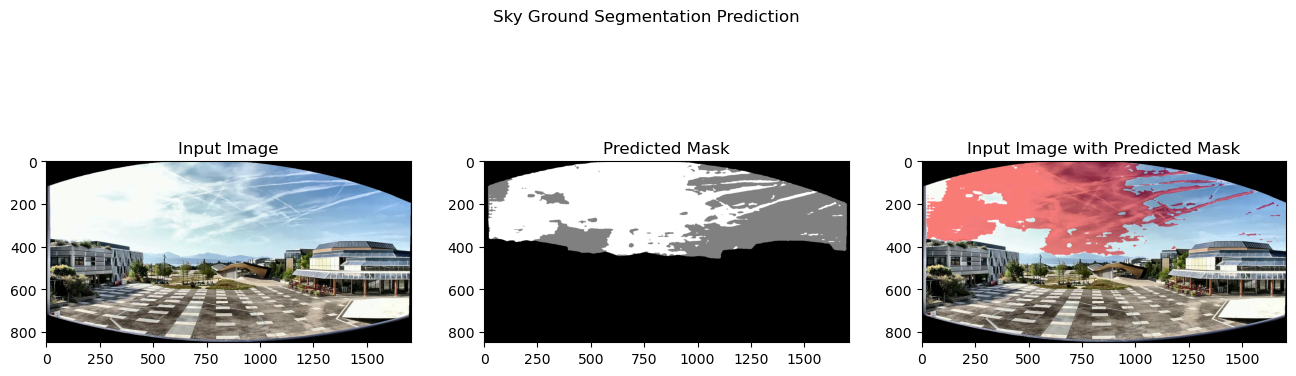

In [27]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene06.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

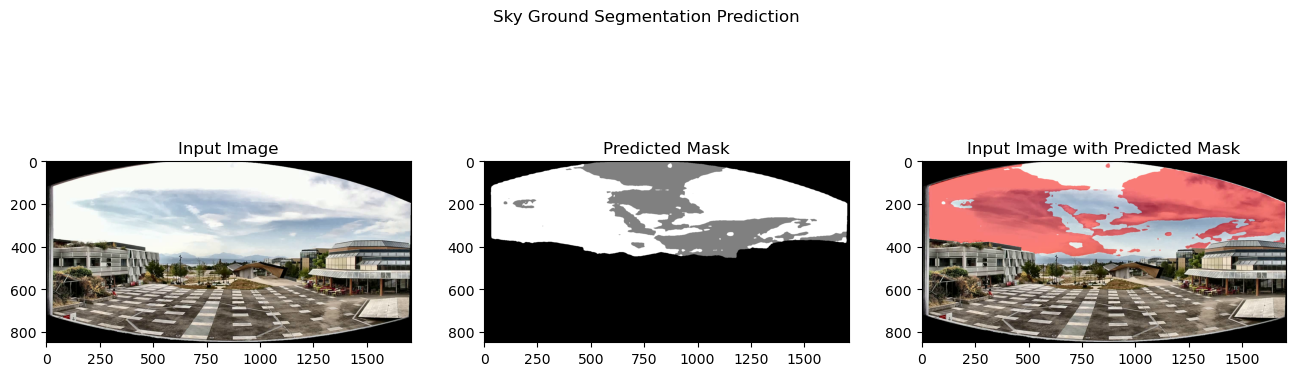

In [28]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene07.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

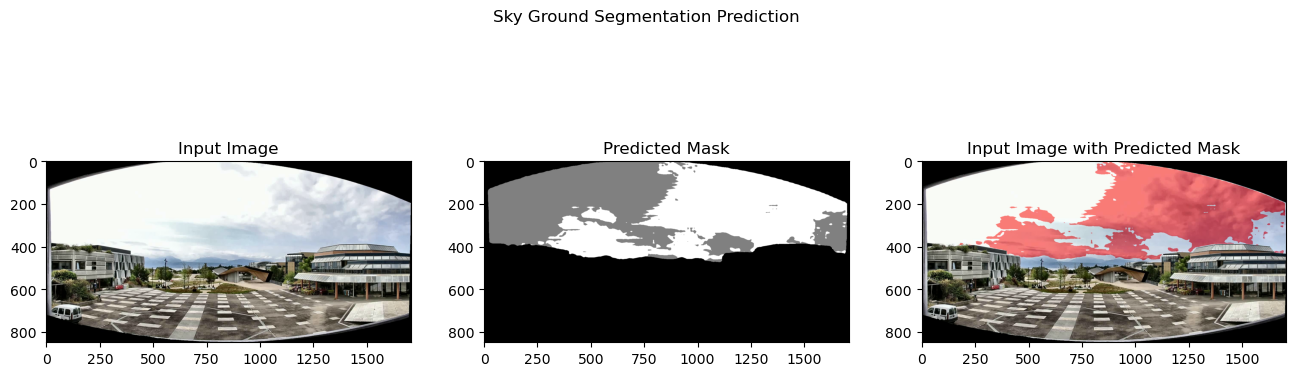

In [29]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene08.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

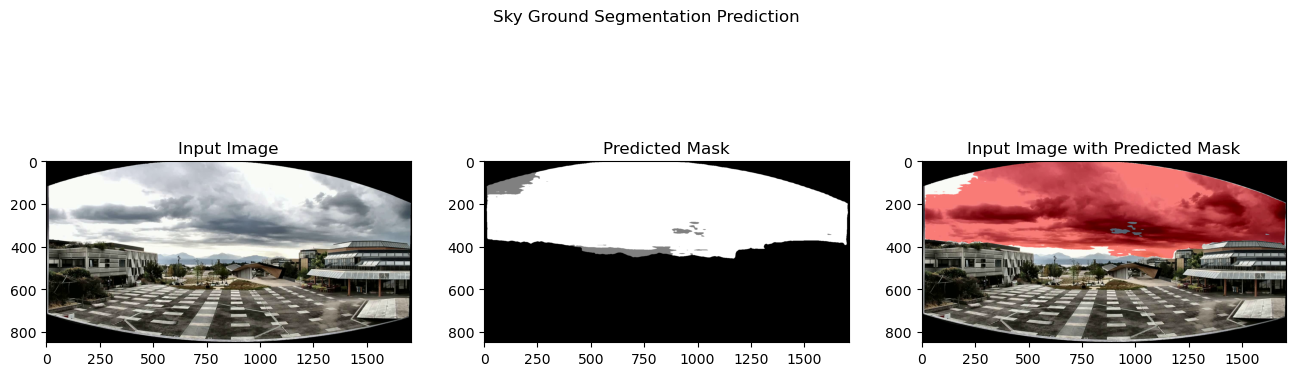

In [30]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene09.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)

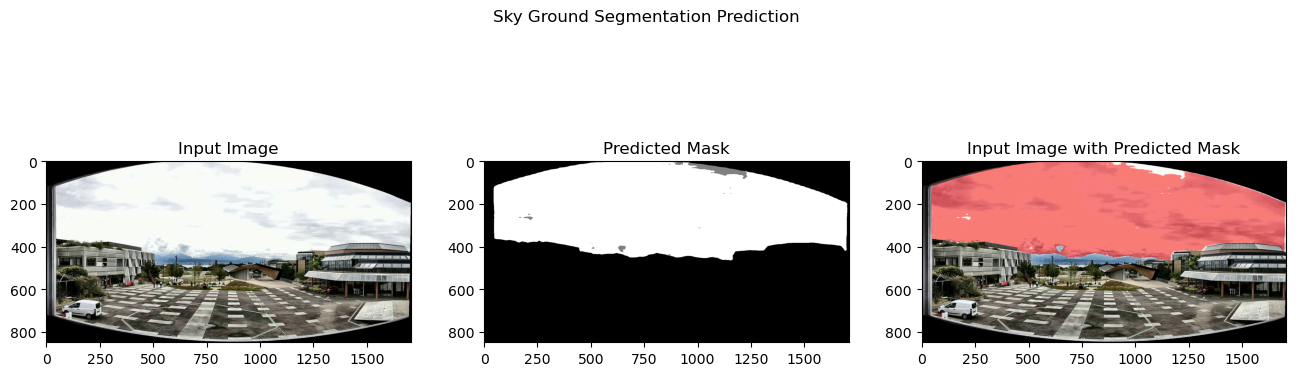

In [31]:
video_example_path = DATA_PATH + 'preprocessing/processed_reframed_scenes/Scene10.mp4'
show_prediction_from_video_frame(cloud_model, video_example_path, frame_idx=2)